In [ ]:
import logging
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

logging.basicConfig(
    filename="scraper.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

logging.info("Запуск скрапинга")

url = "https://www.airlineratings.com/airlines"
driver = webdriver.Chrome()
driver.get(url)

records = []
page = 1

try:
    while True:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "table tbody tr"))
        )

        soup = BeautifulSoup(driver.page_source, "html.parser")

        for row in soup.select("table tbody tr"):
            cols = [td.get_text(strip=True) for td in row.select("td")]
            if len(cols) >= 5:
                records.append(tuple(cols[:5]))

        logging.info(f"Страница {page} обработана (всего {len(records)})")

        next_btn = driver.find_element(By.CSS_SELECTOR, 'li[data-slot="next"]')
        if next_btn.get_attribute("aria-disabled") == "true":
            break

        driver.execute_script("arguments[0].click();", next_btn)
        page += 1
        time.sleep(2)

except Exception as e:
    logging.error(f"Ошибка: {e}")

finally:
    driver.quit()

df1 = pd.DataFrame(records, columns=[
    "Name", "Country", "Passenger Rating", "Product Rating", "Safety Rating"
])

df1.to_csv("airlines_full.csv", index=False, encoding="utf-8-sig")

logging.info(f"Собрано {len(df1)} записей с {page} страниц.")
logging.info("Скрапинг завершён")

In [ ]:
import sys
import time
import itertools
import requests
import pandas as pd
import logging

logging.basicConfig(
    filename="amadeus_parser.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logging.info("Запуск парсинга")

NONSTOP = False
OUT_CSV = "amadeus_raw_all_routes.csv"

SEARCH_DATE = "2025-11-18"

AIRPORTS = [
    "VIE", "BRU", "SOF", "ZAG", "LCA", "PRG", "CPH", "TLL", "HEL",
    "CDG", "BER", "ATH", "BUD", "DUB", "FCO", "RIX", "VNO", "LUX",
    "MLA", "AMS", "WAW", "LIS", "BTS", "LJU", "MAD", "ARN", "LHR",
    "ZRH", "OSL", "KEF", "BEG"
]

routes_all = list(itertools.permutations(AIRPORTS, 2))
total_routes = len(routes_all)

CLIENT_ID = "3eCBDyCPZ0teSGwsgjq4AqC1DW6yy4X0"
CLIENT_SECRET = "l36ehObe0EuGbavA"

AUTH_URL = "https://test.api.amadeus.com/v1/security/oauth2/token"
SEARCH_URL = "https://test.api.amadeus.com/v2/shopping/flight-offers"

session = requests.Session()

def get_token():
    try:
        r = requests.post(AUTH_URL, data={
            "grant_type": "client_credentials",
            "client_id": CLIENT_ID,
            "client_secret": CLIENT_SECRET
        })
        r.raise_for_status()
        token = r.json()["access_token"]
        session.headers["Authorization"] = f"Bearer {token}"
        logging.info("Токен успешно получен.")

def search_offers(origin, dest, dep_date):
    try:
        params = {
            "originLocationCode": origin,
            "destinationLocationCode": dest,
            "departureDate": dep_date,
            "adults": 1,
            "nonStop": str(NONSTOP).lower()
        }
        r = session.get(SEARCH_URL, params=params)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
        logging.info(f"Успешный запрос {origin}->{dest}, найдено {len(data)} офферов.")
        return data
    except Exception as e:
        logging.warning(f"Ошибка при запросе {origin}->{dest}: {e}")
        return []

def parse_offer(offer, origin, dest, dep_date):
    try:
        cabin = offer["travelerPricings"][0]["fareDetailsBySegment"][0]["cabin"]
        if cabin.upper() != "ECONOMY":
            return None

        price_total = float(offer["price"]["total"])
        currency = offer["price"]["currency"]
        airline = offer["validatingAirlineCodes"][0]

        itin = offer["itineraries"][0]
        segs = itin["segments"]
        dep_time = segs[0]["departure"]["at"]
        duration = itin["duration"]

        flight_num = f'{segs[0]["carrierCode"]}-{segs[0]["number"]}'

        return {
            "airline_code": airline,
            "flight_number": flight_num,
            "search_origin": origin,
            "search_destination": dest,
            "search_date": dep_date,
            "departure_date": dep_time,
            "duration": duration,
            "travel_class": cabin,
            "price_total": price_total,
            "currency": currency,
        }
    except Exception as e:
        logging.error(f"Ошибка при парсинге оффера {origin}->{dest}: {e}")
        return None

def fmt_hms(seconds: float) -> str:
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

def update_progress(route_idx, orig, dest, total_rows, kept_last, total_req):
    pct = 100.0 * route_idx / total_routes
    line = (
        f"\r[{route_idx:3d}/{total_routes}] {pct:6.2f}% | "
        f"{orig}->{dest} | взяли: {kept_last:3d} | всего: {total_rows:6d}"
    )
    pad = " " * max(0, 8)
    sys.stdout.write(line + pad)
    sys.stdout.flush()

print(f"Маршрутов: {total_routes}\n")
logging.info(f"Всего маршрутов: {total_routes}")

get_token()

rows = []
total_requests = 0

for i, (orig, dest) in enumerate(routes_all, start=1):
    offers = search_offers(orig, dest, SEARCH_DATE)
    total_requests += 1

    kept = 0
    for ofr in offers:
        k = parse_offer(ofr, orig, dest, SEARCH_DATE)
        if k:
            rows.append(k)
            kept += 1

    update_progress(i, orig, dest, len(rows), kept, total_requests)
    if kept:
        logging.info(f"{orig}->{dest}: сохранено {kept} записей.")

sys.stdout.write("\n")

if rows:
    pd.DataFrame(rows).to_csv(OUT_CSV, index=False)
    print(f"Строк: {len(rows)}. Файл: {OUT_CSV}")
    logging.info(f"Готово. Всего строк: {len(rows)}. Файл: {OUT_CSV}")
else:
    print("Ошибка.")
    logging.error("Нет данных. Проверьте ключи, лимиты или дату.")

In [ ]:
import pandas as pd
df1 = pd.read_csv("airlines_full.csv")
df2 = pd.read_csv("amadeus_raw_all_routes.csv")

In [ ]:
df1

,Name,Country,Passenger Rating,Product Rating,Safety Rating
0,Aegean Airlines,Greece,4.4 / 10,6 / 7,7 / 7
1,Aer Lingus,Ireland,5.9 / 10,4 / 7,7 / 7
2,Aero Contractors,Nigeria,7.5 / 10,1 / 5,7 / 7
3,Aeroflot,Russia,3.8 / 10,4 / 7,1 / 7
4,Aerolineas Argentinas,Argentina,4.6 / 10,4 / 7,7 / 7
...,...,...,...,...,...
309,Wideroe,Norway,4.5 / 10,NaN,7 / 7
310,Wings Air,Indonesia,NaN,NaN,1 / 7
311,Wizz,Hungary,2.9 / 10,1 / 5,7 / 7
312,Xiamen Airlines,China,5.9 / 10,NaN,7 / 7


In [ ]:
df2

,airline_code,flight_number,search_origin,search_destination,search_date,departure_date,duration,travel_class,price_total,currency
0,A3,A3-651,FCO,WAW,2025-11-18,2025-11-18T10:35:00,410,ECONOMY,150.39,EUR
1,A3,A3-655,FCO,WAW,2025-11-18,2025-11-18T18:30:00,1375,ECONOMY,150.39,EUR
2,SK,SK-682,FCO,WAW,2025-11-18,2025-11-18T11:55:00,430,ECONOMY,200.78,EUR
3,AF,AF-1505,FCO,WAW,2025-11-18,2025-11-18T16:20:00,345,ECONOMY,209.40,EUR
4,AF,AF-1205,FCO,WAW,2025-11-18,2025-11-18T09:55:00,385,ECONOMY,209.40,EUR
...,...,...,...,...,...,...,...,...,...,...
52369,A3,A3-757,OSL,ARN,2025-11-18,2025-11-18T12:20:00,705,ECONOMY,425.05,EUR
52370,TK,TK-1754,OSL,ARN,2025-11-18,2025-11-18T18:15:00,985,ECONOMY,432.33,EUR
52371,AF,SK-837,OSL,ARN,2025-11-18,2025-11-18T09:00:00,880,ECONOMY,445.34,EUR
52372,AF,AF-4584,OSL,ARN,2025-11-18,2025-11-18T15:15:00,460,ECONOMY,453.74,EUR


In [ ]:
df2 = df2.drop(columns=["flight_number","search_date","currency","travel_class"])
df2 = df2.drop_duplicates(keep="first")

ign = [c for c in df2.columns if c not in ["departure_date", "duration"]]
df2 = df2.drop_duplicates(subset=ign, keep="first")

df2["price_total"] = pd.to_numeric(df2["price_total"], errors="coerce")
df2 = df2[(df2["price_total"].isna()) | (df2["price_total"] <= 824)]

df2.to_csv("amadeus_raw_all_routes_clean.csv", index=False)

In [ ]:
df2

,airline_code,search_origin,search_destination,departure_date,duration,price_total
0,A3,FCO,WAW,2025-11-18T10:35:00,410,150.39
2,SK,FCO,WAW,2025-11-18T11:55:00,430,200.78
3,AF,FCO,WAW,2025-11-18T16:20:00,345,209.40
7,AF,FCO,WAW,2025-11-18T06:10:00,350,220.41
15,LX,FCO,WAW,2025-11-18T16:50:00,305,242.36
...,...,...,...,...,...,...
52368,AF,OSL,ARN,2025-11-18T07:45:00,335,372.67
52369,A3,OSL,ARN,2025-11-18T12:20:00,705,425.05
52370,TK,OSL,ARN,2025-11-18T18:15:00,985,432.33
52371,AF,OSL,ARN,2025-11-18T09:00:00,880,445.34


In [ ]:
import re


df2 = df2[df2["price_total"].notna() & df2["duration"].notna() & (df2["duration"] > 0)]

df2["price_per_hour"] = df2["price_total"] / (df2["duration"] / 60.0)

grouped = (
    df2.groupby("airline_code", as_index=False)
      .agg(
          price_mean=("price_total", "mean"),
          price_median=("price_total", "median"),
          price_min=("price_total", "min"),
          price_max=("price_total", "max"),
          duration_mean=("duration", "mean"),
          origins_count=("search_origin", "nunique"),
          destinations_count=("search_destination", "nunique"),
          flights_total=("airline_code", "size"),
          price_per_hour_mean=("price_per_hour", "mean"),
      )
)

num_cols = ["price_mean","price_median","price_min","price_max","duration_mean","price_per_hour_mean"]
grouped[num_cols] = grouped[num_cols].round(2)

grouped.to_csv("grouped.csv", index=False)


In [ ]:
grouped

,airline_code,price_mean,price_median,price_min,price_max,duration_mean,origins_count,destinations_count,flights_total,price_per_hour_mean
0,5F,190.60,185.00,163.00,219.00,1140.00,2,4,5,10.90
1,6H,152.29,142.04,104.50,232.98,1093.65,6,7,26,10.67
2,6X,241.91,218.26,48.60,789.30,343.81,9,8,31,75.57
3,A3,284.83,261.21,76.45,804.49,900.77,25,27,956,26.73
4,A9,397.67,200.40,199.88,792.74,1191.67,2,3,3,18.55
...,...,...,...,...,...,...,...,...,...,...
57,V7,131.51,132.83,106.45,150.54,179.64,8,8,14,46.35
58,VF,199.86,189.78,118.92,335.02,1342.04,9,10,27,8.97
59,VY,190.51,190.81,87.52,275.57,556.96,15,15,235,25.59
60,WF,149.63,130.86,99.69,238.69,310.00,2,2,6,32.69


In [ ]:
CODE_TO_NAME = {
    "EI": "Aer Lingus",
    "BT": "Air Baltic",
    "EN": "Air Dolomiti",
    "UX": "Air Europa",
    "AF": "Air France",
    "OS": "Austrian Airlines",
    "S4": "Azores Airlines",
    "SN": "Brussels Airlines",
    "FB": "Bulgaria Air",
    "DE": "Condor Flugdienst",
    "OU": "Croatia Airlines",
    "AY": "Finnair",
    "IB": "Iberia and Iberia Express",
    "AZ": "ITA Airways",
    "LO": "LOT Polish Airlines",
    "LH": "Lufthansa",
    "LG": "Luxair",
    "SK": "SAS",
    "GQ": "Sky Express",
    "QS": "Smartwings",
    "TP": "TAP Portugal",
    "RO": "Tarom",
    "V7": "Volotea",
    "VY": "Vueling",
    "DY": "Norwegian",
    "WF": "Wideroe",
    "FI": "Icelandair",
    "JU": "Air Serbia",
    "LX": "Swiss International Air Lines",
    "GL": "Air Greenland",
    "HY": "Uzbekistan Airways",
    "IZ": "Arkia Israel Airlines",
    "LY": "EL AL Israel Airlines",
    "ME": "Middle East Airlines (MEA)",
    "MS": "EgyptAir",
    "MU": "China Eastern",
    "PC": "Pegasus",
    "QR": "Qatar Airways",
    "RJ": "Royal Jordanian",
    "SV": "Saudia",
    "TK": "Turkish Airlines",
    "XQ": "Sun Express",
    "AH": "Air Algerie",
    "AI": "Air India",
    "AT": "Royal Air Maroc",
    "EK": "Emirates",
    "ET": "Ethiopian Airlines",
    "EY": "Etihad Airways",
    "FZ": "Flydubai",
    "GF": "Gulf Air",
    "6H": "Israir",
    "A9": "Georgian Airways",
}

NAME_TO_CODE = {v: k for k, v in CODE_TO_NAME.items()}

if "airline_code" in grouped.columns:
    grouped["airline_code"] = grouped["airline_code"].astype(str).str.upper().str[:2]

df1["airline_code"] = df1["Name"].map(NAME_TO_CODE)
grouped["Name_from_code"] = grouped["airline_code"].map(CODE_TO_NAME)

df = df1.merge(
    grouped,
    how="inner",
    left_on=["airline_code", "Name"],
    right_on=["airline_code", "Name_from_code"],
    suffixes=("", "_grp")
)

df = df.drop(columns=["Name_from_code"]).drop_duplicates(keep="first")

df.to_csv("airlines_grouped_inner_merged.csv", index=False)

In [ ]:
df

,Name,Country,Passenger Rating,Product Rating,Safety Rating,airline_code,price_mean,price_median,price_min,price_max,duration_mean,origins_count,destinations_count,flights_total,price_per_hour_mean
0,Aer Lingus,Ireland,5.9 / 10,4 / 7,7 / 7,EI,228.28,201.46,71.28,599.88,470.90,11,13,100,61.69
1,Air Algerie,Algeria,4.4 / 10,5 / 7,6 / 7,AH,446.68,468.93,374.99,503.48,1098.00,2,3,5,32.92
2,Air Baltic,Latvia,5.5 / 10,2.5 / 5,7 / 7,BT,229.14,223.86,42.32,820.75,714.92,29,29,923,28.29
3,Air Dolomiti,Italy,4.0 / 10,NaN,7 / 7,EN,406.07,381.86,172.11,816.47,417.73,4,20,44,75.77
4,Air Europa,Spain,3.0 / 10,NaN,7 / 7,UX,255.28,215.35,27.52,774.36,513.16,17,16,144,38.98
5,Air France,France,3.7 / 10,7 / 7,7 / 7,AF,319.97,292.63,106.69,820.93,576.92,30,30,3502,44.70
6,Air Greenland,Greenland,NaN,NaN,7 / 7,GL,724.64,724.64,724.64,724.64,1760.00,1,1,1,24.70
7,Air India,India,3.9 / 10,4.5 / 7,3 / 7,AI,583.99,504.32,470.32,777.32,1355.00,1,2,3,25.99
8,Air Serbia,Serbia,6.2 / 10,NaN,7 / 7,JU,181.97,147.52,52.62,821.79,726.49,22,25,324,23.59
9,Arkia Israel Airlines,Israel,NaN,NaN,7 / 7,IZ,142.46,131.43,116.14,221.70,1276.88,4,4,8,6.79


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

def to_10_scale(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    s = str(x)
    m = re.search(r"(\d+(?:\.\d+)?)\s*/\s*(\d+(?:\.\d+)?)", s)
    if m:
        return (float(m.group(1)) / float(m.group(2))) * 10
    m2 = re.search(r"(\d+(?:\.\d+)?)", s)
    return float(m2.group(1)) if m2 else np.nan

df["Passenger Rating"] = df["Passenger Rating"].apply(to_10_scale)
df["Product Rating"] = df["Product Rating"].apply(to_10_scale)
df["Safety Rating"] = df["Safety Rating"].apply(to_10_scale)

df["Product Rating"].fillna(df["Product Rating"].median(), inplace=True)
df["Passenger Rating"].fillna(df["Passenger Rating"].median(), inplace=True)

df["PEI"] = (df["Passenger Rating"] * df["Product Rating"] * df["Safety Rating"]) / (100 * df["price_per_hour_mean"])

low, high = df["PEI"].quantile(0.05), df["PEI"].quantile(0.95)
df["PEI_clip"] = df["PEI"].clip(lower=low, upper=high)
df["PEI_norm"] = 10 * (df["PEI_clip"] - df["PEI_clip"].min()) / (df["PEI_clip"].max() - df["PEI_clip"].min())

df.drop(columns=["PEI", "PEI_clip"], inplace=True)
df.to_csv("airlines_final.csv", index=False)

/tmp/ipython-input-3574392564.py:21: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-3574392564.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or

In [ ]:
df

,Name,Country,Passenger Rating,Product Rating,Safety Rating,airline_code,price_mean,price_median,price_min,price_max,duration_mean,origins_count,destinations_count,flights_total,price_per_hour_mean,PEI_norm
0,Aer Lingus,Ireland,5.9,5.714286,10.000000,EI,228.28,201.46,71.28,599.88,470.90,11,13,100,61.69,0.780611
1,Air Algerie,Algeria,4.4,7.142857,8.571429,AH,446.68,468.93,374.99,503.48,1098.00,2,3,5,32.92,2.255599
2,Air Baltic,Latvia,5.5,5.000000,10.000000,BT,229.14,223.86,42.32,820.75,714.92,29,29,923,28.29,3.090043
3,Air Dolomiti,Italy,4.0,7.857143,10.000000,EN,406.07,381.86,172.11,816.47,417.73,4,20,44,75.77,0.065786
4,Air Europa,Spain,3.0,7.857143,10.000000,UX,255.28,215.35,27.52,774.36,513.16,17,16,144,38.98,1.096418
5,Air France,France,3.7,10.000000,10.000000,AF,319.97,292.63,106.69,820.93,576.92,30,30,3502,44.70,2.306774
6,Air Greenland,Greenland,4.3,7.857143,10.000000,GL,724.64,724.64,724.64,724.64,1760.00,1,1,1,24.70,5.237780
7,Air India,India,3.9,6.428571,4.285714,AI,583.99,504.32,470.32,777.32,1355.00,1,2,3,25.99,0.058379
8,Air Serbia,Serbia,6.2,7.857143,10.000000,JU,181.97,147.52,52.62,821.79,726.49,22,25,324,23.59,9.021302
9,Arkia Israel Airlines,Israel,4.3,7.857143,10.000000,IZ,142.46,131.43,116.14,221.70,1276.88,4,4,8,6.79,10.000000


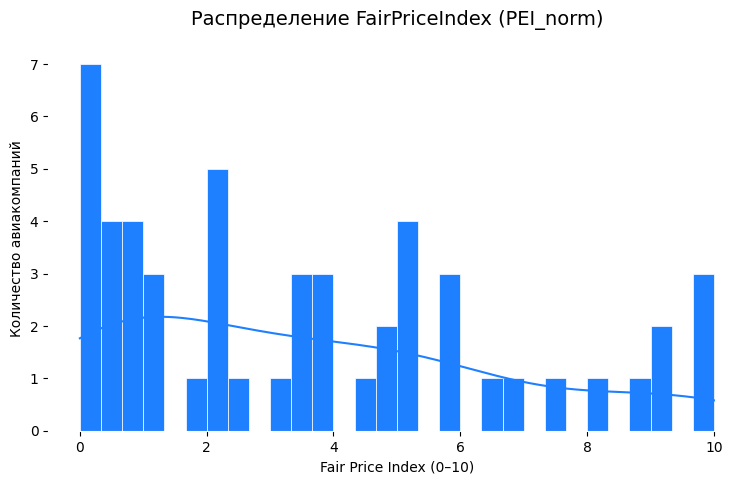

In [ ]:
BG_COLOR = "#ffffff"
PRIMARY = "#1F80FF"
TEXT_COLOR = "#000000"

plt.figure(figsize=(9,5), facecolor=BG_COLOR)

sns.histplot(df["PEI_norm"], kde=True, color=PRIMARY, bins=30, alpha=1, linewidth=0.5)

plt.title("Распределение FairPriceIndex (PEI_norm)", fontsize=14, color=TEXT_COLOR, pad=15)
plt.xlabel("Fair Price Index (0–10)", color=TEXT_COLOR)
plt.ylabel("Количество авиакомпаний", color=TEXT_COLOR)

plt.tick_params(colors=TEXT_COLOR)
plt.gca().set_facecolor(BG_COLOR)


plt.show()

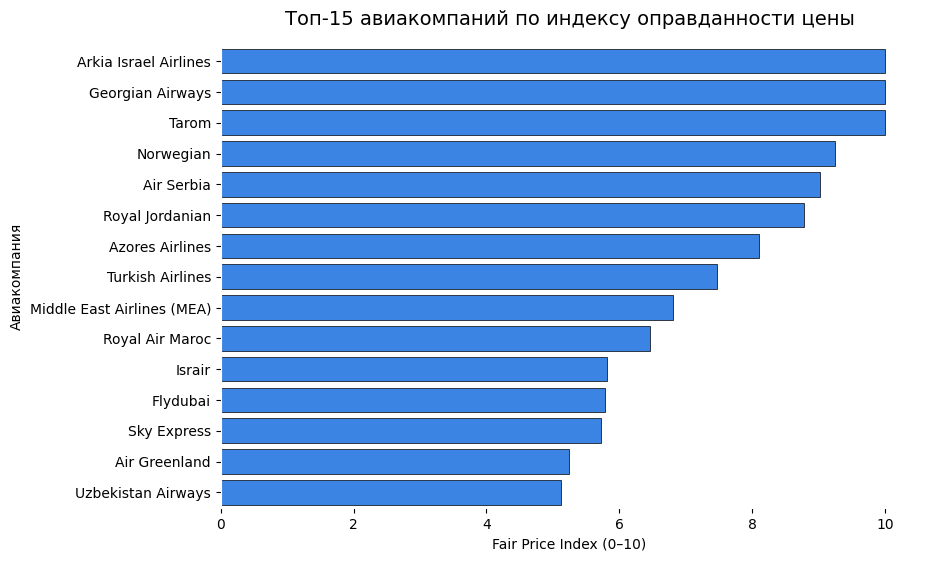

In [ ]:
BG_COLOR = "#ffffff"
PRIMARY = "#1F80FF"
TEXT_COLOR = "#000000"

plt.figure(figsize=(9,6), facecolor=BG_COLOR)

top15 = df.sort_values("PEI_norm", ascending=False).head(15)

sns.barplot(
    data=top15,
    y="Name",
    x="PEI_norm",
    color=PRIMARY,
    alpha=1,
    linewidth=0.5,
    edgecolor="#000000",
)

plt.title("Топ-15 авиакомпаний по индексу оправданности цены", fontsize=14, color=TEXT_COLOR, pad=15)
plt.xlabel("Fair Price Index (0–10)", color=TEXT_COLOR)
plt.ylabel("Авиакомпания", color=TEXT_COLOR)

plt.tick_params(colors=TEXT_COLOR)
plt.gca().set_facecolor(BG_COLOR)

plt.show()

/tmp/ipython-input-1776966603.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



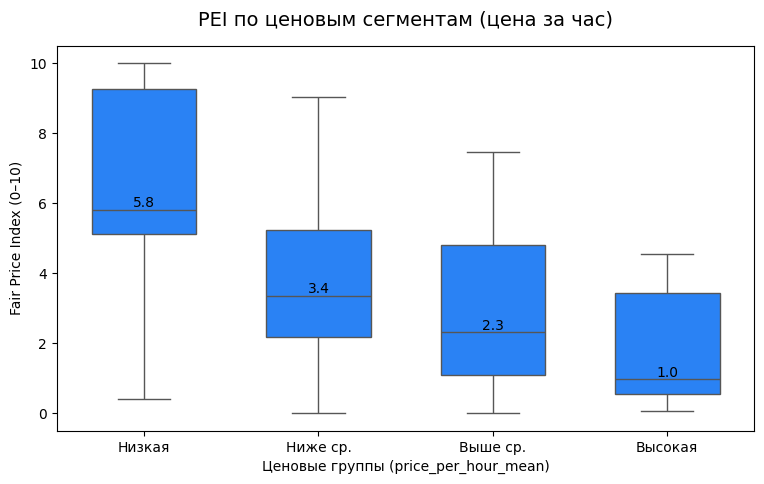

In [ ]:
BG_COLOR   = "#ffffff"
PRIMARY    = "#1F80FF"
TEXT_COLOR = "#000000"

labels = ["Низкая", "Ниже ср.", "Выше ср.", "Высокая"]
df["price_group"] = pd.qcut(df["price_per_hour_mean"], q=4, labels=labels)

plt.figure(figsize=(9,5), facecolor=BG_COLOR)
ax = sns.boxplot(
    data=df, x="price_group", y="PEI_norm",
    color=PRIMARY, width=0.6, fliersize=2, saturation=0.9
)

med = df.groupby("price_group")["PEI_norm"].median().reindex(labels)
for i, v in enumerate(med):
    ax.text(i, v, f"{v:.1f}", ha="center", va="bottom", color=TEXT_COLOR, fontsize=10)

plt.title("PEI по ценовым сегментам (цена за час)", fontsize=14, color=TEXT_COLOR, pad=15)
plt.xlabel("Ценовые группы (price_per_hour_mean)", color=TEXT_COLOR)
plt.ylabel("Fair Price Index (0–10)", color=TEXT_COLOR)

ax.set_facecolor(BG_COLOR)
plt.tick_params(colors=TEXT_COLOR)
for spine in ax.spines.values():
    spine.set_color(TEXT_COLOR)

plt.show()

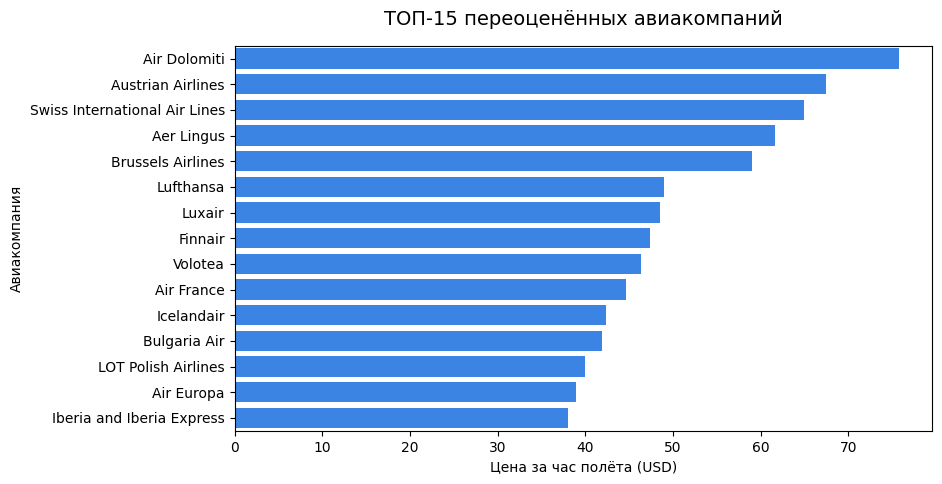

In [ ]:
BG_COLOR = "#ffffff"
PRIMARY = "#1F80FF"
TEXT_COLOR = "#000000"

pei_median = df["PEI_norm"].median()

overpriced = df[
    (df["PEI_norm"] < pei_median) &
    (df["price_per_hour_mean"] > df["price_per_hour_mean"].median())
].sort_values("price_per_hour_mean", ascending=False)

top_overpriced = overpriced.head(15)

plt.figure(figsize=(9,5), facecolor=BG_COLOR)
sns.barplot(
    data=top_overpriced,
    x="price_per_hour_mean", y="Name",
    color=PRIMARY, alpha=1
)

plt.title("ТОП-15 переоценённых авиакомпаний", fontsize=14, color=TEXT_COLOR, pad=15)
plt.xlabel("Цена за час полёта (USD)", color=TEXT_COLOR)
plt.ylabel("Авиакомпания", color=TEXT_COLOR)

plt.tick_params(colors=TEXT_COLOR)
plt.gca().set_facecolor(BG_COLOR)
for spine in plt.gca().spines.values():
    spine.set_color(TEXT_COLOR)

plt.show()

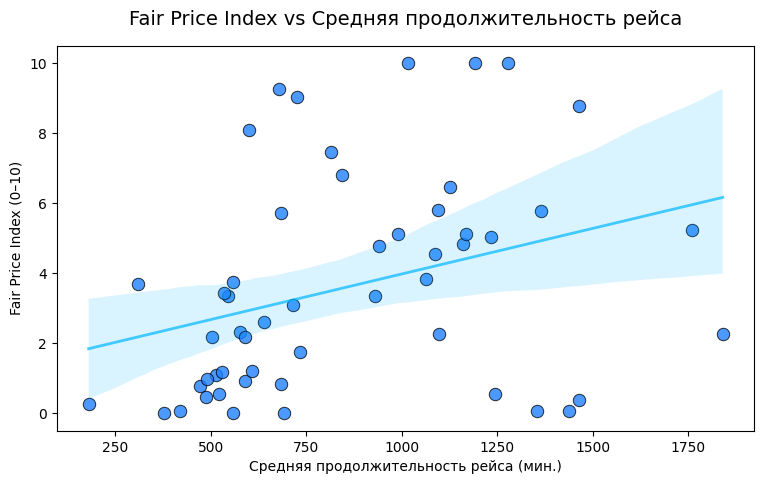

In [ ]:
BG_COLOR = "#ffffff"
PRIMARY = "#1F80FF"
TEXT_COLOR = "#000000"

plt.figure(figsize=(9,5), facecolor=BG_COLOR)

sns.scatterplot(
    data=df,
    x="duration_mean",
    y="PEI_norm",
    color=PRIMARY,
    alpha=0.8,
    s=80, linewidth=0.7, edgecolor = "#000000"
)

sns.regplot(
    data=df,
    x="duration_mean",
    y="PEI_norm",
    scatter=False,
    color="#00b7ff",
    line_kws={"lw":2, "alpha":0.7}
)

plt.title("Fair Price Index vs Средняя продолжительность рейса",
          fontsize=14, color=TEXT_COLOR, pad=15)
plt.xlabel("Средняя продолжительность рейса (мин.)", color=TEXT_COLOR)
plt.ylabel("Fair Price Index (0–10)", color=TEXT_COLOR)

plt.tick_params(colors=TEXT_COLOR)
plt.gca().set_facecolor(BG_COLOR)
for spine in plt.gca().spines.values():
    spine.set_color(TEXT_COLOR)

plt.show()

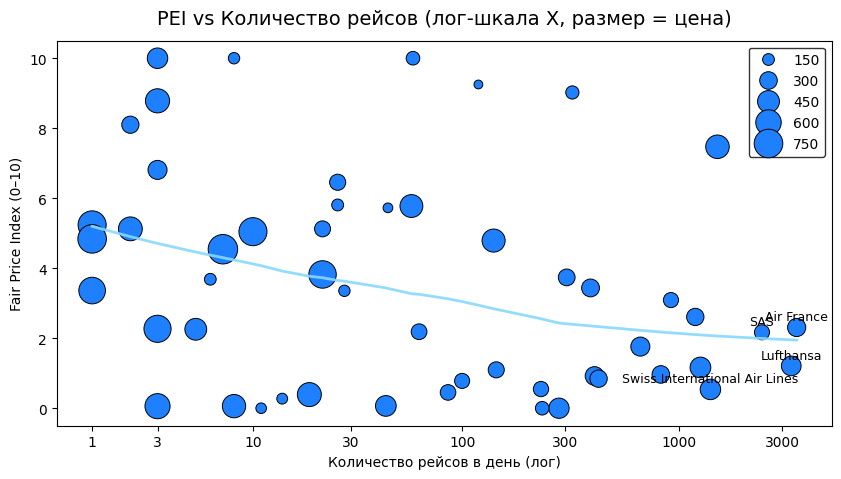

In [ ]:
BG_COLOR = "#ffffff"
PRIMARY = "#1F80FF"
TEXT = "#000000"

df_plot = df.dropna(subset=["flights_total", "PEI_norm", "price_mean"]).copy()
df_plot["flights_total"] = df_plot["flights_total"].clip(lower=1)
df_plot["x_log"] = np.log1p(df_plot["flights_total"])

plt.figure(figsize=(10,5), facecolor=BG_COLOR)

sns.scatterplot(
    data=df_plot,
    x="x_log", y="PEI_norm",
    size="price_mean", sizes=(40, 450),
    color=PRIMARY, alpha=1,
    edgecolor="#000000", linewidth=0.7
)

sns.regplot(
    data=df_plot, x="x_log", y="PEI_norm",
    lowess=True, scatter=False, color="#88d9ff", line_kws={"lw":2, "alpha":0.9}
)

xticks_raw = [1, 3, 10, 30, 100, 300, 1000, 3000]
xticks = np.log1p(xticks_raw)
plt.xticks(xticks, [str(v) for v in xticks_raw], color=TEXT)

worst_big = (
    df_plot.sort_values("flights_total", ascending=False)
           .query("PEI_norm <= 3")
           .head(4)
)

for _, r in worst_big.iterrows():
    plt.text(r["x_log"], r["PEI_norm"]+0.2, r["Name"],
             fontsize=9, color=TEXT, ha="center")

plt.title("PEI vs Количество рейсов (лог-шкала X, размер = цена)", fontsize=14, color=TEXT, pad=12)
plt.xlabel("Количество рейсов в день (лог)", color=TEXT)
plt.ylabel("Fair Price Index (0–10)", color=TEXT)

ax = plt.gca()
ax.set_facecolor(BG_COLOR)
for s in ax.spines.values(): s.set_color(TEXT)
plt.tick_params(colors=TEXT)

legend = plt.legend()
legend.get_frame().set_facecolor("#ffffff")
legend.get_frame().set_edgecolor("#000000")

for txt in legend.get_texts():
    txt.set_color("#000000")

legend.get_title().set_color("#000000")

plt.show()

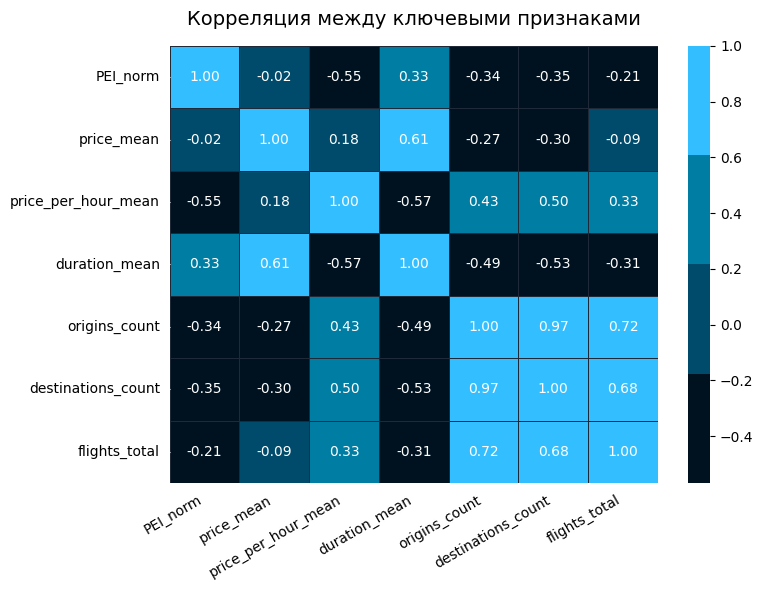

In [ ]:
BG_COLOR = "#ffffff"
TEXT_COLOR = "#000000"

cmap = sns.color_palette(["#001220", "#004b6b", "#007da3", "#33bfff"])
num_cols = ["PEI_norm","price_mean","price_per_hour_mean","duration_mean",
            "origins_count","destinations_count","flights_total"]
corr = df[num_cols].corr()

plt.figure(figsize=(8,6), facecolor=BG_COLOR)

ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    cbar=True,
    annot_kws={"fontsize": 10, "color": "#ffffff"},
    linewidths=0.5,
    linecolor="#1f2937"
)

plt.title("Корреляция между ключевыми признаками", color=TEXT_COLOR, fontsize=14, pad=15)
plt.xticks(color=TEXT_COLOR, rotation=30, ha='right')
plt.yticks(color=TEXT_COLOR, rotation=0)

for t in ax.texts:
    t.set_color("#ffffff")

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(colors=TEXT_COLOR)
cbar.outline.set_edgecolor(TEXT_COLOR)

ax.set_facecolor(BG_COLOR)
for s in ax.spines.values():
    s.set_color(TEXT_COLOR)

plt.tight_layout()
plt.show()

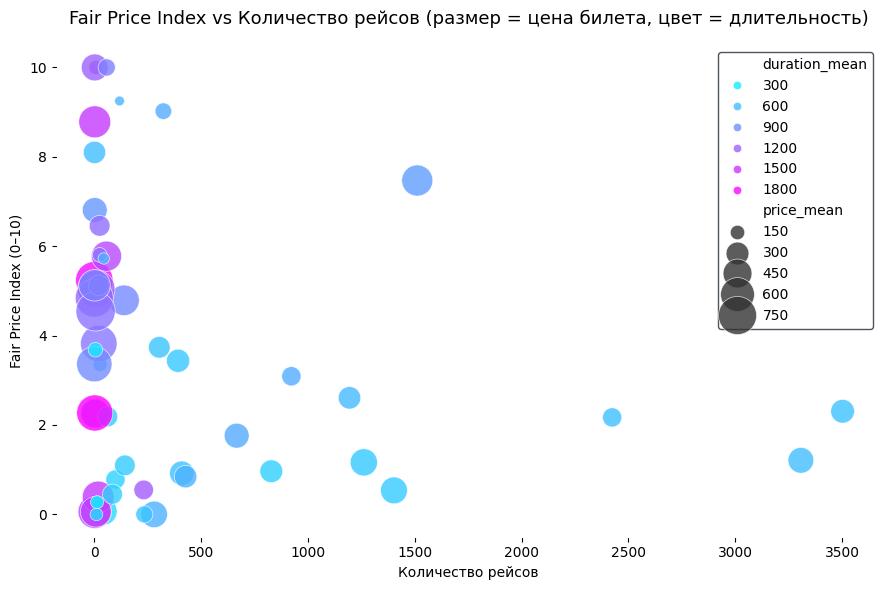

In [ ]:
BG_COLOR = "#ffffff"
PRIMARY = "#1F80FF"
TEXT_COLOR = "#000000"

plt.figure(figsize=(9,6), facecolor=BG_COLOR)

bubble = sns.scatterplot(
    data=df,
    x="flights_total",
    y="PEI_norm",
    size="price_mean",
    hue="duration_mean",
    sizes=(50, 800),
    palette="cool",
    alpha=0.8,
    edgecolor="white",
    linewidth=0.5
)

plt.title("Fair Price Index vs Количество рейсов (размер = цена билета, цвет = длительность)", color=TEXT_COLOR, fontsize=13, pad=15)
plt.xlabel("Количество рейсов", color=TEXT_COLOR)
plt.ylabel("Fair Price Index (0–10)", color=TEXT_COLOR)

plt.legend(
    loc="upper right",
    labelcolor=TEXT_COLOR,
    facecolor=BG_COLOR,
    edgecolor="#1f2937"
)

plt.tick_params(colors=TEXT_COLOR)
plt.gca().set_facecolor(BG_COLOR)

plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

for c in ["PEI_norm", "price_per_hour_mean", "flights_total", "destinations_count"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

g = (df.groupby("Country", as_index=False)
       .agg(PEI_mean=("PEI_norm","mean"),
            price_per_hour_mean=("price_per_hour_mean","mean"),
            airlines_count=("airline_code","nunique"),
            flights_total=("flights_total","sum"),
            destinations_total=("destinations_count","sum")))

BG = "#ffffff"
TEXT = "#000000"
scale = [(0, "#0b2a38"), (0.5, "#1e7aa5"), (1, "#33bfff")]

fig = px.choropleth(
    g,
    locations="Country",
    locationmode="country names",
    color="PEI_mean",
    scope="europe",
    color_continuous_scale=scale,
    title="Средний Fair Price Index по странам (Европа)",
    hover_data={
        "Country": True,
        "PEI_mean":":.2f",
        "airlines_count": True,
        "price_per_hour_mean":":.0f",
        "flights_total": True,
        "destinations_total": True
    }
)

fig.update_geos(
    visible=False,
    resolution=50,
    showcountries=True,
    countrycolor="#20232a",
    projection_type="mercator",
    center=dict(lat=54, lon=15),
    lonaxis_range=[-25, 45],
    lataxis_range=[35, 70]
)

fig.update_layout(
    width=950, height=700,
    paper_bgcolor=BG, plot_bgcolor=BG,
    font_color=TEXT,
    coloraxis_colorbar=dict(title="PEI"),
    geo_bgcolor=BG,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

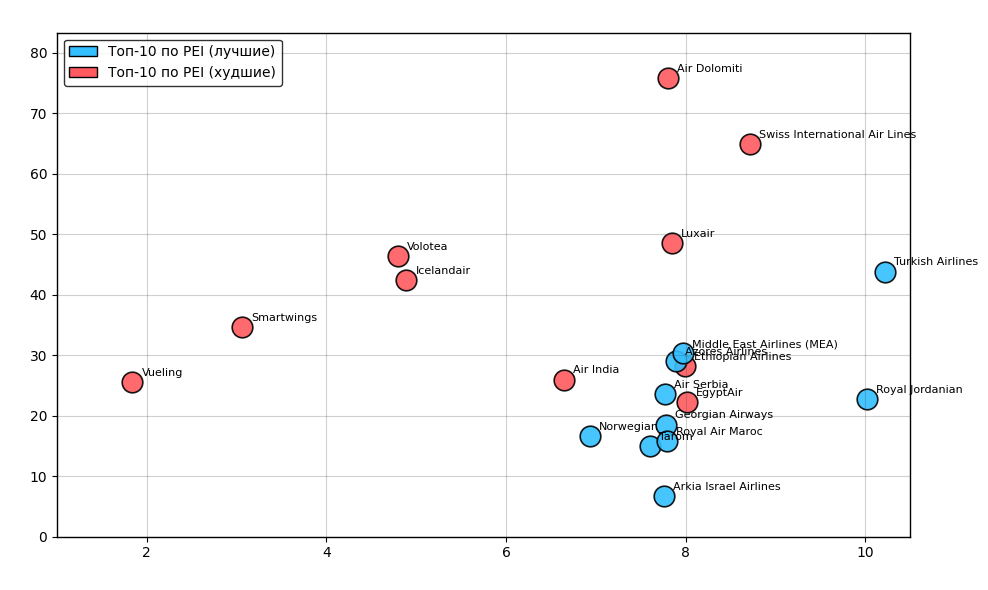

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

BG, TEXT, BORDER = "#ffffff", "#000000", "#000000"
BEST, WORST = "#33bfff", "#ff5a5f"

base = df[["Name", "Product Rating", "price_per_hour_mean", "PEI_norm"]].dropna()
best10  = base.nlargest(10, "PEI_norm")
worst10 = base.nsmallest(10, "PEI_norm")

best10["Product Rating_jit"]  = best10["Product Rating"]  + np.random.normal(0, 0.12, len(best10))
worst10["Product Rating_jit"] = worst10["Product Rating"] + np.random.normal(0, 0.12, len(worst10))

fig, ax = plt.subplots(figsize=(10, 6), facecolor=BG)

sns.scatterplot(
    data=worst10, x="Product Rating_jit", y="price_per_hour_mean",
    s=220, color=WORST, edgecolor=BORDER, linewidth=1.2, alpha=0.9
)
sns.scatterplot(
    data=best10, x="Product Rating_jit", y="price_per_hour_mean",
    s=220, color=BEST, edgecolor=BORDER, linewidth=1.2, alpha=0.9
)

for _, r in pd.concat([best10, worst10]).iterrows():
    ax.text(r["Product Rating_jit"]+0.1, r["price_per_hour_mean"]+1,
            r["Name"], fontsize=8, color=TEXT)

ax.set(
    title="Карта баланса: качество vs цена (топ-10 лучших и худших по PEI)",
    xlabel="Рейтинг продукта (0–10)",
    ylabel="Цена за час, EUR",
    xlim=(1, 10.5),
    ylim=(0, base["price_per_hour_mean"].max() * 1.1)
)
ax.set_facecolor(BG)
ax.tick_params(colors=TEXT)
ax.grid(alpha=0.25, color="#444444")

for spine in ax.spines.values():
    spine.set_color(BORDER)
    spine.set_linewidth(1)

handles = [
    Patch(facecolor=BEST, edgecolor=BORDER, label="Топ-10 по PEI (лучшие)"),
    Patch(facecolor=WORST, edgecolor=BORDER, label="Топ-10 по PEI (худшие)")
]
legend = ax.legend(handles=handles, loc="upper left", frameon=True, facecolor=BG, edgecolor=BORDER)
plt.setp(legend.get_texts(), color=TEXT)

plt.tight_layout()
plt.show()

1. «Оптимальный баланс» — высокая оправданность, разумная цена
Кто: Middle East Airlines (MEA), Georgian Airways, Tarom, Royal Air Maroc, Norwegian, Arkia Israel Airlines
Профиль:  Цена: 10–30 EUR/час  Рейтинг: 7–9   PEI_norm ≥ 8
2. «Премиум-эффективные» — высокая цена, но оправдана качеством
Кто: Turkish Airlines, Royal Jordanian, Air Serbia, Azores Airlines
Профиль: Цена: 25–45 EUR/час  Рейтинг: 8–10  PEI_norm 7–9
3. «Псевдопремиум» — дорого, но не стоит своих денег
Кто: Swiss International Air Lines, Air Dolomiti, Luxair
Профиль:  Цена: 45–80 EUR/час Рейтинг: 8–9  PEI_norm ≤ 4
4. «Low-cost без выгоды» — дешево, но не оправдано даже за эти деньги
Кто: Vueling, Smartwings, Volotea, Icelandair, Air India
Профиль:  Цена: 25–45 EUR/час  Рейтинг: 2–6  PEI_norm ≤ 3